In [1]:
%env CUDA_LAUNCH_BLOCKING=1
import torch
from torch import nn
from torch.utils.data import DataLoader
from src.data.data_synth import DNFDataset
from src.model import fuzzy_logic
from src.model import embed_logic
from src.model.fuzzy_layer import FuzzyDNF
from src.model.embed_layer import EmbedDNF
from src.plot import plot_loss, plot_bit_density
from src.dnf import format_dnf, format_vars
import matplotlib.pyplot as plt

env: CUDA_LAUNCH_BLOCKING=1


In [2]:
%%capture
from tqdm.notebook import tqdm
tqdm().pandas()

In [3]:
device = 'cpu'
#device = 'cuda'

In [4]:
def train_dnf(model: FuzzyDNF, dataloader, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr)
    loss_fn = torch.nn.BCELoss()

    seen = 0
    items = []
    obs_losses = []
    props = []
    dnf_strs = []
    prev_dnf_params = None

    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = X.to(device)
        y = y.to(device)
        pred = torch.squeeze(model(X))
        loss = loss_fn(pred, y)

        # Optimise NN model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        """
        dnf_params = model.harden_params()
        if prev_dnf_params == None or not all(map(torch.equal, prev_dnf_params, dnf_params)):
            dnf_strs.append(model.params_to_str())
            prev_dnf_params = tuple(map(lambda t: t.clone().detach(), dnf_params))
        """
        seen += len(X)
        items.append(seen)
        obs_losses.append(loss.item())
        props.append(y.mean())
        
    return torch.tensor(items), torch.tensor(obs_losses), torch.tensor(props), dnf_strs

In [5]:
dnf_dataset = DNFDataset(10, 100, 0.5, 2, 0.5)
for X, y in dnf_dataset:
    print(format_vars(X))
    print("Given formula:")
    print(format_dnf(dnf_dataset.conj_signs, dnf_dataset.conj_weights))
    print("Produces:")
    print(str(y) + "\n")

( ¬0 ∧ ¬1 ∧ 2 ∧ ¬3 ∧ ¬4 ∧ 5 ∧ 6 ∧ 7 ∧ ¬8 ∧ 9 )
Given formula:
( 1 ∧ ¬3 ∧ ¬4 ∧ 7 ∧ 8 ∧ 9 )
∨ ( 1 ∧ ¬2 ∧ ¬3 ∧ ¬4 ∧ 7 ∧ ¬8 ∧ ¬9 )
Produces:
tensor(0.)

( ¬0 ∧ ¬1 ∧ 2 ∧ ¬3 ∧ ¬4 ∧ ¬5 ∧ 6 ∧ 7 ∧ ¬8 ∧ ¬9 )
Given formula:
( 1 ∧ ¬3 ∧ ¬4 ∧ 7 ∧ 8 ∧ 9 )
∨ ( 1 ∧ ¬2 ∧ ¬3 ∧ ¬4 ∧ 7 ∧ ¬8 ∧ ¬9 )
Produces:
tensor(0.)

( 0 ∧ ¬1 ∧ 2 ∧ ¬3 ∧ 4 ∧ 5 ∧ ¬6 ∧ ¬7 ∧ ¬8 ∧ 9 )
Given formula:
( 1 ∧ ¬3 ∧ ¬4 ∧ 7 ∧ 8 ∧ 9 )
∨ ( 1 ∧ ¬2 ∧ ¬3 ∧ ¬4 ∧ 7 ∧ ¬8 ∧ ¬9 )
Produces:
tensor(0.)

( 0 ∧ 1 ∧ 2 ∧ 3 ∧ ¬4 ∧ ¬5 ∧ ¬6 ∧ 7 ∧ ¬8 ∧ ¬9 )
Given formula:
( 1 ∧ ¬3 ∧ ¬4 ∧ 7 ∧ 8 ∧ 9 )
∨ ( 1 ∧ ¬2 ∧ ¬3 ∧ ¬4 ∧ 7 ∧ ¬8 ∧ ¬9 )
Produces:
tensor(0.)

( 0 ∧ 1 ∧ ¬2 ∧ 3 ∧ 4 ∧ ¬5 ∧ ¬6 ∧ ¬7 ∧ 8 ∧ 9 )
Given formula:
( 1 ∧ ¬3 ∧ ¬4 ∧ 7 ∧ 8 ∧ 9 )
∨ ( 1 ∧ ¬2 ∧ ¬3 ∧ ¬4 ∧ 7 ∧ ¬8 ∧ ¬9 )
Produces:
tensor(0.)

( 0 ∧ ¬1 ∧ ¬2 ∧ ¬3 ∧ ¬4 ∧ ¬5 ∧ 6 ∧ ¬7 ∧ 8 ∧ 9 )
Given formula:
( 1 ∧ ¬3 ∧ ¬4 ∧ 7 ∧ 8 ∧ 9 )
∨ ( 1 ∧ ¬2 ∧ ¬3 ∧ ¬4 ∧ 7 ∧ ¬8 ∧ ¬9 )
Produces:
tensor(0.)

( ¬0 ∧ ¬1 ∧ 2 ∧ 3 ∧ ¬4 ∧ 5 ∧ ¬6 ∧ ¬7 ∧ ¬8 ∧ 9 )
Given formula:
( 1 ∧ ¬3 ∧ ¬4 ∧ 7 ∧ 8 ∧ 9 )
∨ ( 1 ∧ ¬2 ∧ 

In [6]:
class FuzzyNN(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.logic = fuzzy_logic.ProductLogic()
        self.model = nn.Sequential(
            FuzzyDNF((in_features, 16, 4), logic=self.logic),
            FuzzyDNF((4, 16, 1), logic=self.logic),
        )

    def forward(self, input):
        return self.model(input)

  0%|          | 0/1563 [00:00<?, ?it/s]

[]


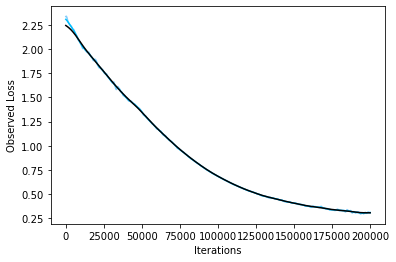

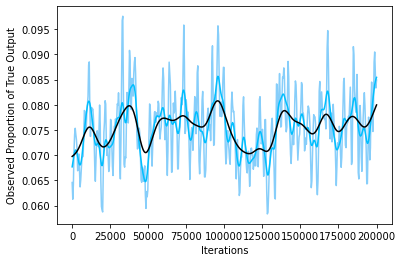

In [10]:
dnf_dim = 10
dnf_dataset = DNFDataset(dnf_dim, 200000, 0.5, 2, 0.5)
dnf_dataloader = DataLoader(dnf_dataset, batch_size=128, shuffle=True)

dnf_model = FuzzyNN(dnf_dim)
dnf_model.to(device)

dnf_items, dnf_losses, dnf_props, dnf_strs = train_dnf(dnf_model, dnf_dataloader, lr=1e-3)

print(dnf_strs)

plot_loss(dnf_items, dnf_losses, ylabel='Observed Loss', approx=True)
plot_loss(dnf_items, dnf_props, ylabel='Observed Proportion of True Output', approx=True)

In [8]:
class PerceptronDNF(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input)

  0%|          | 0/1563 [00:00<?, ?it/s]

[]


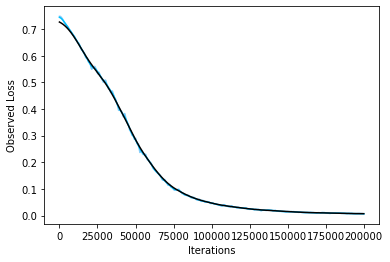

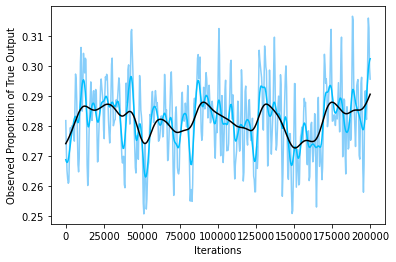

In [12]:
dnf_dim = 10
dnf_dataset = DNFDataset(dnf_dim, 200000, 0.5, 2, 0.5)
dnf_dataloader = DataLoader(dnf_dataset, batch_size=128, shuffle=True)

dnf_model = PerceptronDNF(dnf_dim)
dnf_model.to(device)

dnf_items, dnf_losses, dnf_props, dnf_strs = train_dnf(dnf_model, dnf_dataloader, lr=5e-4)

print(dnf_strs)

plot_loss(dnf_items, dnf_losses, ylabel='Observed Loss', approx=True)
plot_loss(dnf_items, dnf_props, ylabel='Observed Proportion of True Output', approx=True)

In [4]:
def train_embed_dnf(model: nn.Module, dataloader, optim, reg_weight=1e-2):
    loss_fn = torch.nn.BCELoss()

    seen = 0
    items = []
    obs_losses = []
    props = []

    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = X.to(device)
        y = y.to(device)
        pred = torch.squeeze(model(X))
        loss = loss_fn(pred, y)

        # Optimise NN model
        optim.zero_grad()
        (loss + reg_weight * model.logic.logic_reg()).backward()
        optim.step()
        model.logic.zero_reg()
        
        seen += len(X)
        items.append(seen)
        obs_losses.append(loss.item())
        props.append(y.mean())
        
    return torch.tensor(items), torch.tensor(obs_losses), torch.tensor(props)

In [5]:
class EmbedNN(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.logic = embed_logic.EmbedLogic(5)
        self.model = nn.Sequential(
            EmbedDNF((in_features, 10, 1), logic=self.logic),
        )

    def forward(self, input):
        return self.logic.decode(self.model(self.logic.encode(input)))

  0%|          | 0/1172 [00:00<?, ?it/s]

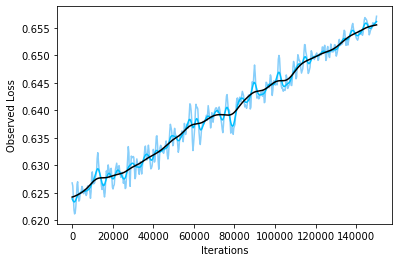

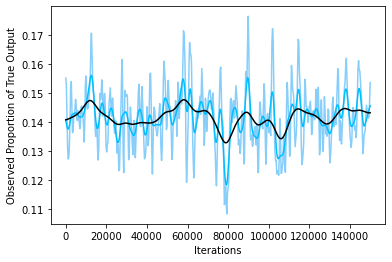

In [11]:
embed_input_dim = 10
embed_dataset = DNFDataset(embed_input_dim, 150000, 0.5, 2, 0.5)
embed_dataloader = DataLoader(embed_dataset, batch_size=128, shuffle=True)

embed_model = EmbedNN(embed_input_dim)
embed_model.to(device)
embed_optimizer = torch.optim.Adam(embed_model.parameters(), lr=1e-4)

embed_items, embed_losses, embed_props = train_embed_dnf(embed_model, embed_dataloader, embed_optimizer, 1e-3)
#dnf_items2, dnf_losses2, dnf_props2, _ = train_dnf(dnf_model, dnf_dataloader, lr=1e-4)

#dnf_items = torch.cat((dnf_items, dnf_items.max() + dnf_items2), dim=0)
#dnf_losses = torch.cat((dnf_losses, dnf_losses2), dim=0)
#dnf_props = torch.cat((dnf_props, dnf_props2), dim=0)

plot_loss(embed_items, embed_losses, ylabel='Observed Loss', approx=True)
plot_loss(embed_items, embed_props, ylabel='Observed Proportion of True Output', approx=True)

dnf_model.logic

In [7]:
embed_model.logic.neg(embed_model.logic.F())

tensor([ 2.0790,  1.1620, -0.1542,  0.6676,  0.7764], grad_fn=<SumBackward1>)

In [32]:
dnf_losses[-1]

tensor(0.3057)

In [8]:
embed_model.logic.F()

tensor([ 0.8225, -0.7053,  0.3399, -0.2153, -0.2256], grad_fn=<SumBackward1>)

In [9]:
embed_model.logic._not.w_1

Parameter containing:
tensor([[ 0.5621,  1.2540, -0.5607, -0.1701,  0.3843],
        [-0.0525,  1.3031,  0.3383,  0.1996, -0.7837],
        [ 0.1067,  0.8521, -0.3867,  0.6217, -0.0410],
        [-1.1409,  0.7848,  0.3334, -0.4837, -0.3707],
        [-0.8682,  1.1505,  0.1770, -0.4649, -0.1673]], requires_grad=True)

In [23]:
embed_model.logic._not.b_1

Parameter containing:
tensor([0.0644, 0.3523, 0.5141, 0.0650, 1.0525], requires_grad=True)

In [24]:
embed_model.logic._not.w_2

Parameter containing:
tensor([[ 1.0623,  0.1752,  0.0927,  0.2727,  0.7591],
        [ 1.1405,  0.1183,  0.2403,  0.7657,  0.6517],
        [ 1.8183, -0.3554,  0.1039,  0.4057,  0.0208],
        [ 1.0518,  0.3153,  0.3070,  0.4794,  0.2886],
        [ 1.7147,  0.1656, -0.0597, -0.2277, -0.0731]], requires_grad=True)